# **Analyzing NYC Police Stop Data**

![picture](https://drive.google.com/uc?export=view&id=1jdT-dFYKVGSPE7B0_wXbpclC_4UyqrIP)

*by Ben Lewis and Jessy Han*

*MIT, Initiative on Combatting Systemic Racism - Policing Lab*

Bias in the criminal justice system can lead to poor decision making, leaving lasting impacts on individuals' lives. The Policing Lab at MIT's Initiative on Combatting Systemic Racism (ICSR) is dedicated to making dispatcher info, police stop info, and criminal sentencing data publicly available for professors, students, researchers, and anyone else interested in using these data to reduce bias in the field of criminal justice. With the help of Amazon Web Services (AWS), were doing just that.

To get a better understanding of the type of anaylsis one can do with this data, we've put together a demonstration using real police stop records from NYC. To see work done by the NYC ACLU using NYC Stop data, check out the articles [Stop-and-Frisk Data](https://www.nyclu.org/en/stop-and-frisk-data) and [A Closer Look at Stop-and-Frisk in NYC](https://www.nyclu.org/en/closer-look-stop-and-frisk-nyc)

In this demo, we will use police stop data from New York City in 2013. We'll walk you through how to:
1. Access the data in a GitHub Repository
2. Explore the data through tables and data visualizations
3. How to uncover potential racial biases using Principle Component Analysis (PCA)



In [1]:
!pip install geoplot
!pip install openpyxl

## Run this code to import the `numpy` and `pandas` library

In [2]:
import numpy as np
import pandas as pd

from datetime import datetime, timedelta
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap

from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

import geopandas as gpd
import geoplot as gplt
from cartopy import crs

import requests
from zipfile import ZipFile
import io

In [3]:
# num_of_years = 20

## Setting the stage with a Time Series Plot

Below we have some code that produces a graph which highlights changes in police stops overtime.

We'll start by reading in data from our github repository for the years 2003-2021.

In [4]:

# dfs = [0 for i in range(num_of_years)]
# for i, year in enumerate(range(2003, 2023)):
#     # get the right url for data
#     if year < 2015:
#         url = "https://www.nyc.gov/assets/nypd/downloads/zip/analysis_and_planning/stop-question-frisk/sqf-%s-csv.zip" % year
#     elif year < 2017:
#         url = "https://www.nyc.gov/assets/nypd/downloads/excel/analysis_and_planning/stop-question-frisk/sqf-%s.csv" % year
#     elif year == 2017:
#         url = "https://www.nyc.gov/assets/nypd/downloads/excel/analysis_and_planning/stop-question-frisk/csi-2947-2019-sqf-cy2017-updated1-9-2020.xlsx"
#     else:
#         url = "https://www.nyc.gov/assets/nypd/downloads/excel/analysis_and_planning/stop-question-frisk/sqf-%s.xlsx" % year

#     if year < 2015:
#         response = requests.get(url, stream=True, verify=False)
#         with ZipFile(io.BytesIO(response.content)) as myzip:
#             with myzip.open(myzip.namelist()[0]) as myfile:
#                 if year in [2003, 2004, 2008, 2009, 2011]:
#                     dfs[i] = pd.read_csv(myfile, encoding='latin-1') #encoding= 'unicode_escape'
#                 else:
#                     dfs[i] = pd.read_csv(myfile)
#     elif year < 2017:
#         dfs[i] = pd.read_csv(url)
#     else:
#         dfs[i] = pd.read_excel(url)

In [5]:
num_of_years = 18

dfs = [0 for i in range(num_of_years)]
for i, year in enumerate(range(2003, 2021)):
  if year < 2017:
    url = 'https://github.com/benblewis/MIT_AWS_Demo/blob/main/sqf-%s.csv?raw=true' % year
  else :
    url = 'https://github.com/benblewis/MIT_AWS_Demo/blob/main/sqf-%s.xlsx?raw=true' % year

  if year in [2003, 2004, 2008, 2009, 2011]:
    dfs[i] = pd.read_csv(url, encoding='latin-1') #encoding= 'unicode_escape'
  elif year in [2005, 2006, 2007, 2010, 2012, 2013, 2014, 2015, 2016]:
    dfs[i] = pd.read_csv(url)
  else:
    dfs[i] = pd.read_excel(url)


/tmp/ipykernel_394/1672798710.py:11: DtypeWarning: Columns (81,82,83,84,85) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs[i] = pd.read_csv(url, encoding='latin-1') #encoding= 'unicode_escape'
/tmp/ipykernel_394/1672798710.py:11: DtypeWarning: Columns (4,102,109,110) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs[i] = pd.read_csv(url, encoding='latin-1') #encoding= 'unicode_escape'
/tmp/ipykernel_394/1672798710.py:13: DtypeWarning: Columns (10,73,83) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs[i] = pd.read_csv(url)
/tmp/ipykernel_394/1672798710.py:13: DtypeWarning: Columns (10,83) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs[i] = pd.read_csv(url)
/tmp/ipykernel_394/1672798710.py:13: DtypeWarning: Columns (0,1,2,3,4,8,18,19,73,74,84,85,86,103,110,111) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs[i] = pd.read_csv(url)


Now we'll plot the number of stops between 2003 and 2023 using the `.plot()` function, where the range of years will be our x-axis and the number of observations for each year is our y-axis.

Text(0.5, 1.0, 'Trend of number of stops in NYC')

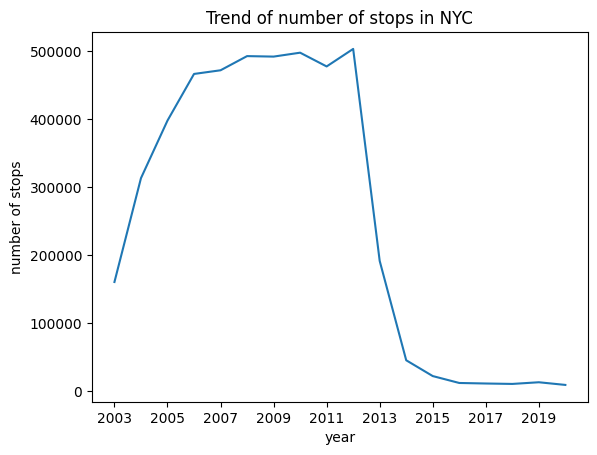

In [6]:
plt.plot(range(2003, 2021), [len(df) for df in dfs])
plt.xticks(range(2003, 2021, 2))
plt.xlabel("year")
plt.ylabel("number of stops")
plt.title("Trend of number of stops in NYC")

We can clearly see the number of stops reached a peak in year 2011 and started to decline drastically since than.

## How are Stops initiated?

Now lets see how many stop interactions were initiated by calls. We'll grab this information by using the 'radio' column for the first 14 years of data, and by using the 'STOP_WAS_INITIATED' column for the remaining years. We'll use the .mean() function to find the ratio of stops that were initiated by calls.

In [7]:
call_initiated_ratio = [0 for i in range(num_of_years)]
for i in range(num_of_years):
    if i < 14:
        call_initiated_ratio[i] = (dfs[i]['radio']=='Y').mean()
    else:
        call_initiated_ratio[i] = (dfs[i]['STOP_WAS_INITIATED']=='Based on Radio Run').mean()

Below is a time series plot of the ratio of stops initiated by 911 calls between 2003 and 2023.

Text(0.5, 1.0, 'Trend of call-initiated stop ratio in NYC')

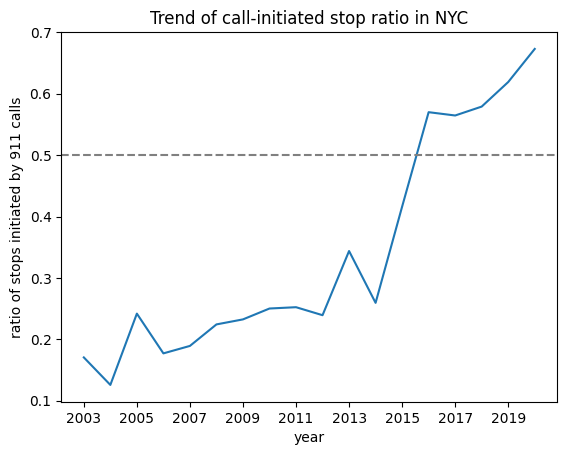

In [8]:
plt.plot(range(2003, 2021), call_initiated_ratio)
plt.axhline(y=0.5, color='grey', linestyle='--')
plt.xticks(range(2003, 2021, 2))
plt.xlabel("year")
plt.ylabel("ratio of stops initiated by 911 calls")
plt.title("Trend of call-initiated stop ratio in NYC")

We see that after 2015, more than half of the stops are initiated by 911 calls. Thus, to get a more complete picture of NYC policing and criminal justice system, you are encouraged to explore the 911 call dataset [here](https://data.cityofnewyork.us/Public-Safety/NYPD-Calls-for-Service-Historic-/d6zx-ckhd)

## Run this code to read in the csv file that contains the 2013 NYC Stop data from GitHub

In [9]:
url = "https://github.com/benblewis/MIT_AWS_Demo/blob/main/sqf-2013.csv?raw=true"
nyc_stop_2013 = pd.read_csv(url, index_col=0)
nyc_stop_2013 = nyc_stop_2013[["city","race","crimsusp","rf_knowl","pf_hcuff","pf_ptwep","radio","arstmade"]]

/tmp/ipykernel_394/1127553967.py:2: DtypeWarning: Columns (10,73,83) have mixed types. Specify dtype option on import or set low_memory=False.
  nyc_stop_2013 = pd.read_csv(url, index_col=0)


## The Data at a Glance

We'll use the `.head()` function to view the first 5 rows of our nyc_stop_2013 dataframe

In [10]:
# use .head() to view first few rows of stop data
nyc_stop_2013.head()

,city,race,crimsusp,rf_knowl,pf_hcuff,pf_ptwep,radio,arstmade
year,,,,,,,,
2013,MANHATTAN,B,GRAND LARCENY,N,N,N,N,N
2013,MANHATTAN,A,GRAND LARCENY,N,N,N,N,N
2013,MANHATTAN,B,ROBBERY,N,N,N,N,N
2013,MANHATTAN,B,ROBBERY,N,N,N,N,N
2013,MANHATTAN,B,BURGLARY,N,N,N,N,N


We'll use the `len()` function to see how many rows are in our dataset.

In [11]:
# check number of rows in each dataset
print(len(nyc_stop_2013))

191851


## Viewing the columns

Next we'll use `.columns` to check out the features our police stop dataset. Understanding the types of data collected is a crucial starting point for our analysis.

In [12]:
#Print of columns in each dataset
print("Stop Columns")
print(nyc_stop_2013.columns)


Stop Columns
Index(['city', 'race', 'crimsusp', 'rf_knowl', 'pf_hcuff', 'pf_ptwep', 'radio',
       'arstmade'],
      dtype='object')


## Clean The Data

Below we change `'city'` to `'boro'` , `'race'` to `'suspect_race'`, `'crimsusp`' to `'suspected_crime'`, `'rf_knowl'` to `'suspect_prior_aggressive_crime'`, `'pf_hcuff'` to `'stop_force_handcuff'`, `'pf_ptwep'` to `'stop_force_firearm'`, and `'arstmade'` to `'arrest_flag'`. We also replace the borough names with A, B, C, D, and E.

Finally we subset the data for observations where the suspect identifies as A (Asian), B (Black), Q (Hispanic), or W (White).

In [13]:
# some data cleaning. This part may have to be done outside of the demo so that certain column names are changed before we shoot the demo
nyc_stop_2013 = nyc_stop_2013.rename(columns={'city':'boro','race':'suspect_race','crimsusp':'suspected_crime','rf_knowl':'suspect_prior_aggressive_crime','pf_hcuff':'stop_force_handcuff','pf_ptwep':'stop_force_firearm','radio':'call','arstmade':'arrest_flag'})
nyc_stop_2013['boro'].unique()
nyc_stop_2013['boro_masked'] = nyc_stop_2013['boro'].replace({'MANHATTAN':"A", 'BRONX':"B", 'BROOKLYN':"C", 'QUEENS':"D", 'STATEN ISLAND':"E", 'STATEN IS':"E"})
nyc_stop_2013 = nyc_stop_2013[nyc_stop_2013['suspect_race'].isin(['A','B','Q','W'])]
nyc_stop_2013['suspect_race'] = nyc_stop_2013['suspect_race'].replace({'A':'Asian','B':'Black','Q':'Hispanic','W':'White'})
nyc_stop_2013 = nyc_stop_2013.drop(columns=['boro',])
print(nyc_stop_2013.columns)

Index(['suspect_race', 'suspected_crime', 'suspect_prior_aggressive_crime',
       'stop_force_handcuff', 'stop_force_firearm', 'call', 'arrest_flag',
       'boro_masked'],
      dtype='object')


## Missing Values

Here we sum up the missing values for each of the columns in our dataset using `.isna()`. We use the `.to_string()` function to list the entirety of columns/NA's. Try printing the amount of NAs without the `.to_string()` function. You'll see it only provides the first and last five columns/NA sums.

In [14]:
# number of NAs in each column for the two datasets
print("Stop NAs")
print(nyc_stop_2013.isna().sum().to_string())

Stop NAs
suspect_race                      0
suspected_crime                   2
suspect_prior_aggressive_crime    0
stop_force_handcuff               0
stop_force_firearm                0
call                              0
arrest_flag                       0
boro_masked                       0


## Key Categorical Variables

Here we use the `.value_counts()` function to see the amount of observations we have for each category in a few of our key categorical variables. We want to find the relationship between race, location, and police force, so we'll count up the observations for each category in
* suspect_race
* stop location borough
* suspected/alleged crime
* stop force:
  * handcuff
  * firearm
* call (denotes whether or not the stop was initiated by a 911 call)

In [15]:
# view counts for key categorical variables
print("**Race Counts**")
print(nyc_stop_2013['suspect_race'].value_counts())
print(" ")
print("**Borough Counts**")
print(nyc_stop_2013['boro_masked'].value_counts())
print(" ")
print("**Crime Counts**")
print(nyc_stop_2013['suspected_crime'].value_counts())
print(" ")
print("**Stop Force Handcuff**")
print(nyc_stop_2013['stop_force_handcuff'].value_counts())
print(" ")
print("**Stop Force Firearm**")
print(nyc_stop_2013['stop_force_firearm'].value_counts())

**Race Counts**
suspect_race
Black       104449
Hispanic     42659
White        20820
Asian         6845
Name: count, dtype: int64
 
**Borough Counts**
boro_masked
C    67697
D    42562
A    34376
B    21916
E     8222
Name: count, dtype: int64
 
**Crime Counts**
suspected_crime
FEL                32181
FELONY             29924
MISD               25688
CPW                18582
ROBBERY            12356
                   ...  
COMM ROBBERY           1
MISDERMEANOR           1
MISDEAMER              1
GRAND ;LARCENY         1
1034 (SHOOTING)        1
Name: count, Length: 2469, dtype: int64
 
**Stop Force Handcuff**
stop_force_handcuff
N    165836
Y      8937
Name: count, dtype: int64
 
**Stop Force Firearm**
stop_force_firearm
N    174166
Y       607
Name: count, dtype: int64


## Grouping Key Categorical Variables

Here we use the `.groupby()` function, grouping by race to see how many observation are from each borough for a given race.

In [16]:
#view subset of boro's by race
print(nyc_stop_2013[['suspect_race','boro_masked']].groupby(['suspect_race']).value_counts().to_string())

suspect_race  boro_masked
Asian         D               3849
              C               1877
              A                795
              B                227
              E                 97
Black         C              45299
              D              22809
              A              19556
              B              13129
              E               3656
Hispanic      C              12105
              D              11385
              A              10117
              B               7637
              E               1415
White         C               8416
              D               4519
              A               3908
              E               3054
              B                923


## Grouping Continued

We can also group by race to see the distribution of folks arrested by race. We use `'SUSPECT_ARRESTED_FLAG'` where `'Y'` means the suspect was arrested and `'N'` means the suspect was released before arrest.

Further, we can group by race and borough location to see the distribution of folks arrested by race in a given borough.

In [17]:
# count of arrests by race
print("**Arrested Flag grouped by Race**")
print(nyc_stop_2013[['suspect_race','arrest_flag']].groupby(['suspect_race']).value_counts().to_string())
print(" ")
print("**Arrested Flag grouped by Race and Borough**")
print(nyc_stop_2013[['suspect_race','boro_masked','arrest_flag']].groupby(['suspect_race','boro_masked']).value_counts().to_string())


**Arrested Flag grouped by Race**
suspect_race  arrest_flag
Asian         N               6235
              Y                610
Black         N              96795
              Y               7654
Hispanic      N              38670
              Y               3989
White         N              19100
              Y               1720
 
**Arrested Flag grouped by Race and Borough**
suspect_race  boro_masked  arrest_flag
Asian         A            N                705
                           Y                 90
              B            N                207
                           Y                 20
              C            N               1743
                           Y                134
              D            N               3487
                           Y                362
              E            N                 93
                           Y                  4
Black         A            N              17337
                           Y               22

# Data Visualization

Now that we've seen summaries of the data in tabular form, let's visualize the data so that it's easier for ourselves and our audience to digest. We'll start by importing `matplotlib`, a popular data viz library.

In [18]:
# first we'll grab our handy visualization tools

import matplotlib.pyplot as plt
#%matplotlib inline

Let's take a look at the number of people stoped in each borough by race. To do that, first we make an object called `boro_by_race` that breaks down the number of people of each race in each of our 5 boroughs.

Next, we write a for-loop that loops through each borough in `boro_by_race` and creates a race demographic barchart for each borough.

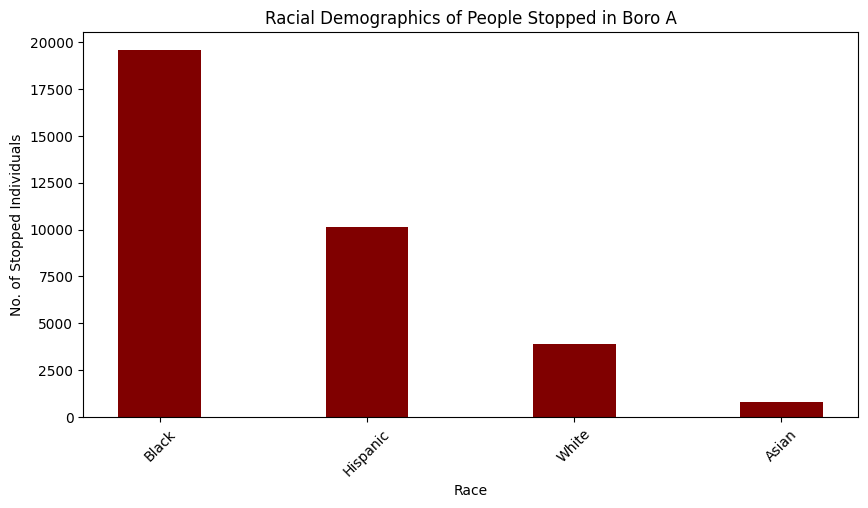

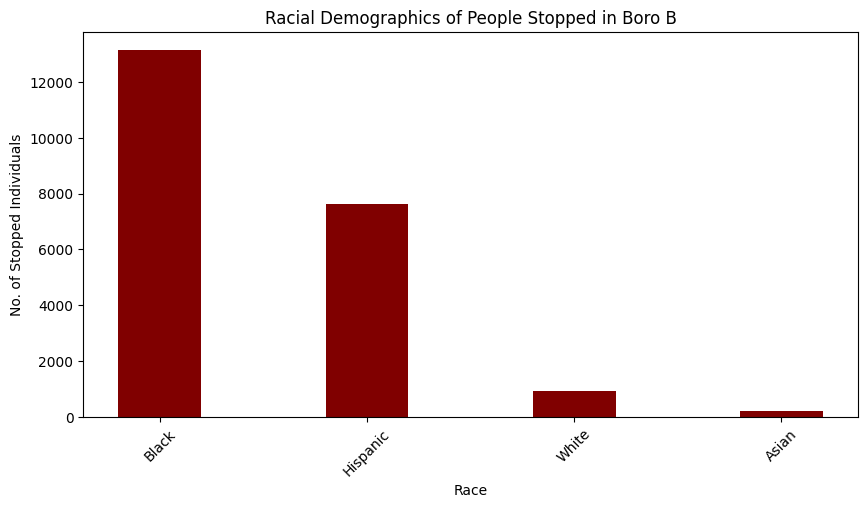

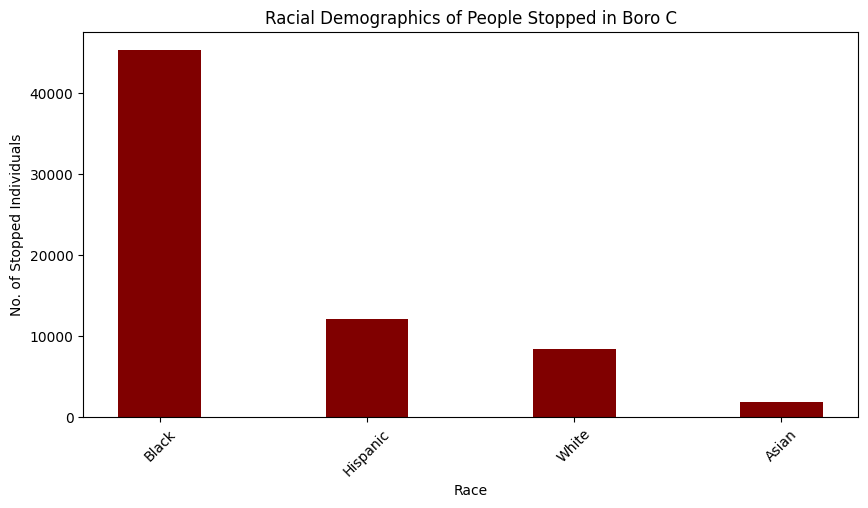

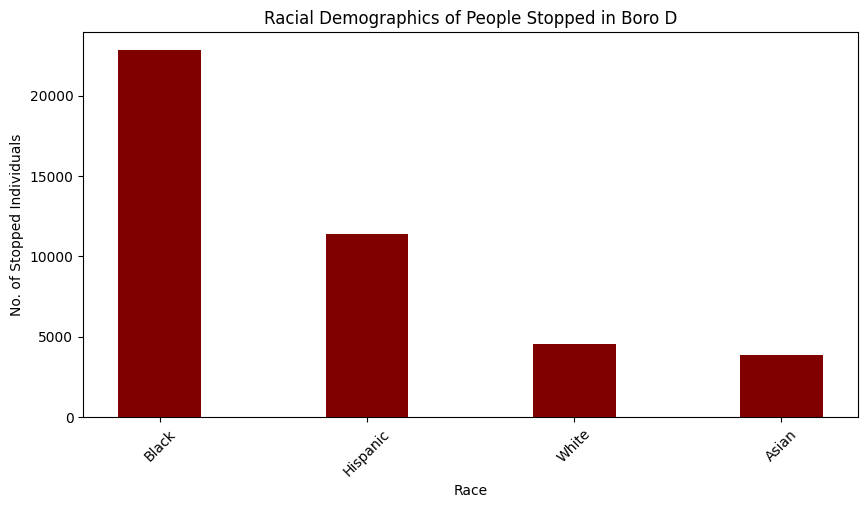

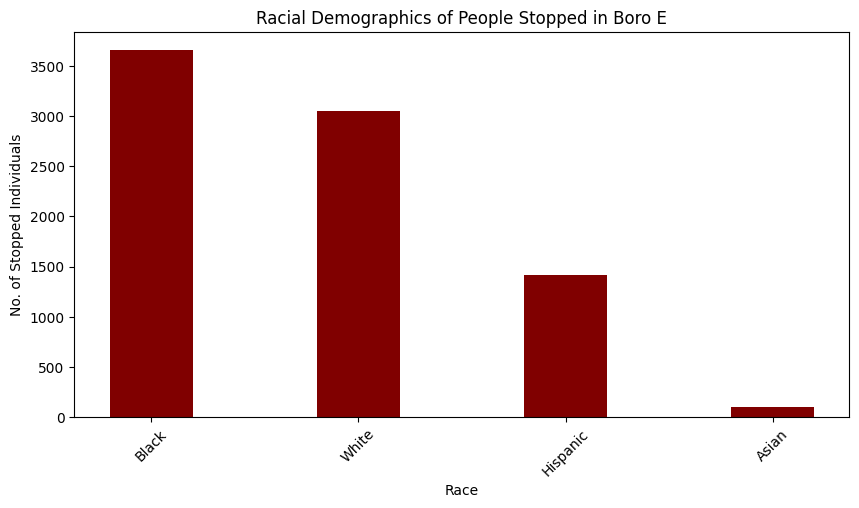

In [19]:
# number of people stopped in each boro by race
boro_by_race = (nyc_stop_2013[['boro_masked','suspect_race']].groupby(['boro_masked']).value_counts().reset_index())


for i in list(boro_by_race["boro_masked"].unique()):
  boro_i = boro_by_race[boro_by_race["boro_masked"] == i]
  race = list(boro_i["suspect_race"])
  counts = list(boro_i["count"])
  fig = plt.figure(figsize = (10, 5))

  # creating the bar plot
  plt.bar(race, counts, color ='maroon',
          width = 0.4)

  plt.xlabel("Race")
  plt.xticks(rotation = 45)
  plt.ylabel("No. of Stopped Individuals")
  plt.title("Racial Demographics of People Stopped in Boro " + i)
  plt.show()
  print(" ")

In [20]:
num_of_race = 4
num_of_boro = 5

## Grouped Bar Charts

Looking at the number of people stopped by race for each boro individually can come in handy if you just want to zero in on one boro, but we can also represent this data all on one graph using a grouped bar chart. Below we use `.set_index()` to index our data by borough and race, then use `.plot.bar()` to create the grouped bar chart.

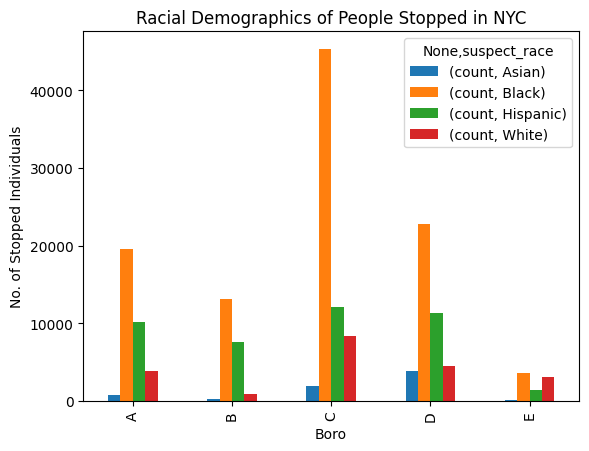

In [21]:
# number of people stopped in each boro by race
boro_by_race = (nyc_stop_2013[['boro_masked','suspect_race']].groupby(['boro_masked']).value_counts().reset_index())
boro_by_race = boro_by_race.set_index(['boro_masked','suspect_race']).unstack()

boro_by_race.plot.bar()
plt.ylabel("No. of Stopped Individuals")
plt.xlabel("Boro")
plt.title("Racial Demographics of People Stopped in NYC" )
plt.show()

Similarly, we can display the number of stopped individuals having a background of aggression or not by race using a grouped bar chart. We'll use similar code from above, except this time, we'll index by `'suspect_race'` and `'suspect_prior_aggressive_crime'` and count up the number of `N`'s and `Y`'s for each race.

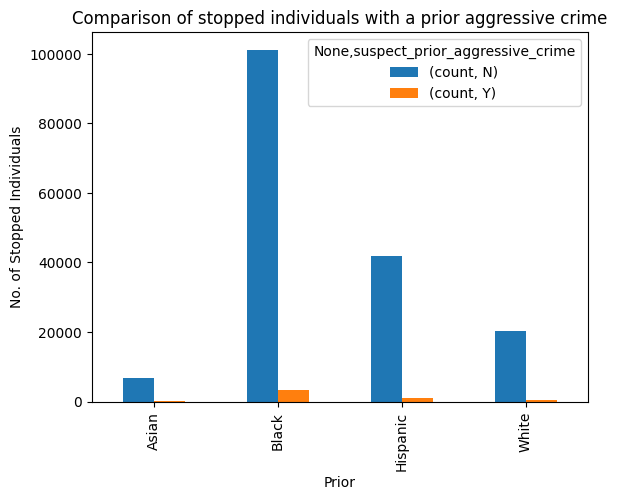

In [22]:
# prior aggression flag by race
prior_by_race = (nyc_stop_2013[['suspect_race','suspect_prior_aggressive_crime']].groupby(['suspect_race']).value_counts().reset_index())
prior_by_race = prior_by_race.set_index(['suspect_race','suspect_prior_aggressive_crime']).unstack()

prior_by_race.plot.bar()
plt.ylabel("No. of Stopped Individuals")
plt.xlabel("Prior")
plt.title("Comparison of stopped individuals with a prior aggressive crime")
plt.show()

Now let's look at the number of people by race for which a firearm was used in the stop interaction by the police officer. Again, grouping by and looping through `'suspect_race'` to count up `'stop_force_firearm'` we'll create bar charts that tell us the number of stops that  involved police firearm use for each race.

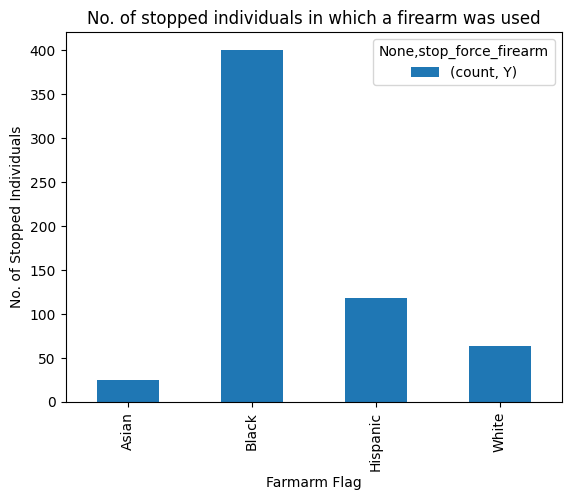

In [23]:
# prior aggression flag by race
firearm_by_race = (nyc_stop_2013[['suspect_race','stop_force_firearm']].groupby(['suspect_race']).value_counts().reset_index())
firearm_by_race = firearm_by_race[firearm_by_race["stop_force_firearm"] != "N"]
firearm_by_race = firearm_by_race.set_index(['suspect_race','stop_force_firearm']).unstack()

firearm_by_race.plot.bar()
plt.ylabel("No. of Stopped Individuals")
plt.xlabel("Farmarm Flag")
plt.title("No. of stopped individuals in which a firearm was used")
plt.show()

## Arrest Rates

Now we will look at the rate of crime by race and by borough for observations that involved a suspect with a flag for a prior aggressive charge. We'll start by subsetting our data to include only observations where `nyc_stop_2013['suspect_prior_aggressive_crime']=='Y'`. We need the count of people arrested in each race and the count of people in each race to calculate arrest rate. So next we'll use `.size()` to count the number of people in each race who were arrested and have a prior aggressive charge and save these values as `race_prior`. We'll also use `.size()` to count the number of people in each race and save these values as `race_counts`. After changing race_prior and race_counts to dataframes, and setting stop_race to string, we then divide the number of people arrested with a prior aggressive charge by race (found in race_prior) by the number with a prior aggressive charge of people in each race (found in race_counts). .Finally, we produce our bar chart of Crime Rates by Race.

To get crime rates by borough, we use the exact same code, but replace `'suspect_race'` with `'boro_masked'`

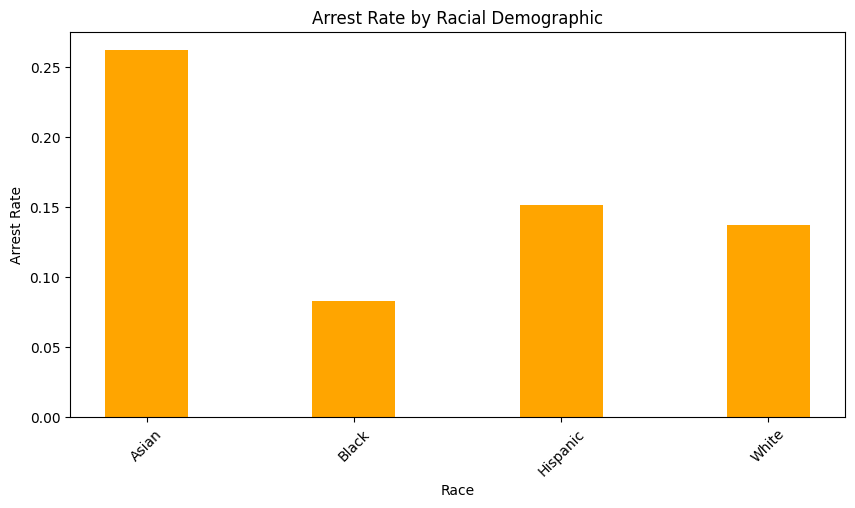

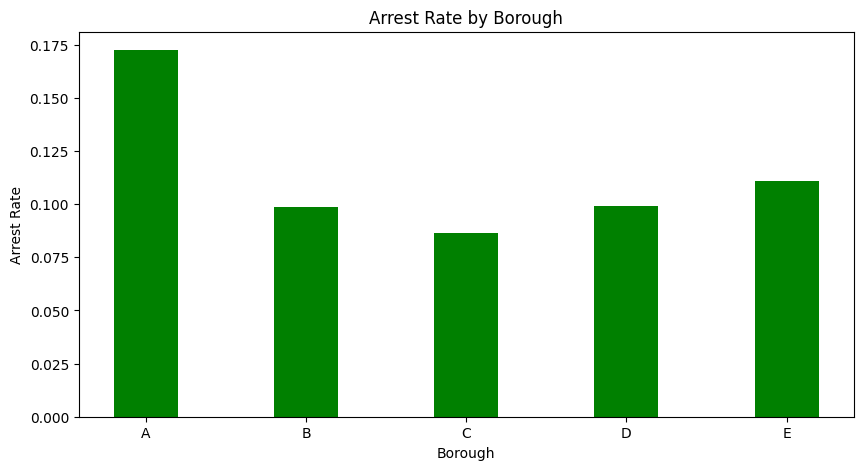

In [24]:
# subset for background with aggressive flag
aggressive_prior = nyc_stop_2013[(nyc_stop_2013['suspect_prior_aggressive_crime']=='Y') & (nyc_stop_2013["suspect_race"] != "(null)")]

# find arrest rate by race
race_prior = aggressive_prior[['suspect_race','arrest_flag']].groupby(['suspect_race','arrest_flag']).size().reset_index(name='counts')
race_counts = aggressive_prior.groupby(['suspect_race']).size().reset_index(name='counts')
df_race_prior = pd.DataFrame(race_prior, columns = ["suspect_race","arrest_flag","counts"])
df_race_counts = pd.DataFrame(race_counts, columns = ["suspect_race","counts"])
df_race_counts = df_race_counts.rename(columns={"counts":"total"})
df_race_prior.suspect_race = df_race_prior.suspect_race.astype(str)
df_race_counts.suspect_race = df_race_counts.suspect_race.astype(str)
pct_table = pd.merge(df_race_prior, df_race_counts, on = "suspect_race", how="left")
pct_table = pct_table[(pct_table['arrest_flag'] != "N")]
pct_table['percentage'] = pct_table['counts']/pct_table['total']
# graph arrest rate by race
labels = list(pct_table['suspect_race'])
sizes = list(pct_table['percentage'])
fig = plt.figure(figsize = (10, 5))
plt.bar(labels, sizes, color ='orange',
          width = 0.4)
plt.xticks(rotation = 45)
plt.xlabel("Race")
plt.ylabel("Arrest Rate")
plt.title("Arrest Rate by Racial Demographic")
plt.show()

print(" ")
# find arrest rate by boro
boro_prior = aggressive_prior[['boro_masked','arrest_flag']].groupby(['boro_masked','arrest_flag']).size().reset_index(name='counts')
boro_counts = aggressive_prior.groupby(['boro_masked']).size().reset_index(name='counts')
df_boro_prior = pd.DataFrame(boro_prior, columns = ["boro_masked","arrest_flag","counts"])
df_boro_counts = pd.DataFrame(boro_counts, columns = ["boro_masked","counts"])
df_boro_counts = df_boro_counts.rename(columns={"counts":"total"})
df_boro_prior.boro_masked = df_boro_prior.boro_masked.astype(str)
df_boro_counts.boro_masked = df_boro_counts.boro_masked.astype(str)
pct_table2 = pd.merge(df_boro_prior, df_boro_counts, on = "boro_masked", how="left")
pct_table2 = pct_table2[(pct_table2['arrest_flag'] != "N")]
pct_table2['percentage'] = pct_table2['counts']/pct_table2['total']
# graph arrest rate by boro
labels = list(pct_table2['boro_masked'])
sizes = list(pct_table2['percentage'])
fig = plt.figure(figsize = (10, 5))
plt.bar(labels, sizes, color ='green',
          width = 0.4)
plt.xlabel("Borough")
plt.ylabel("Arrest Rate")
plt.title("Arrest Rate by Borough")
plt.show()




Now lets look at arrest rate by boro and by race together. Again we'll use a grouped bar chart.

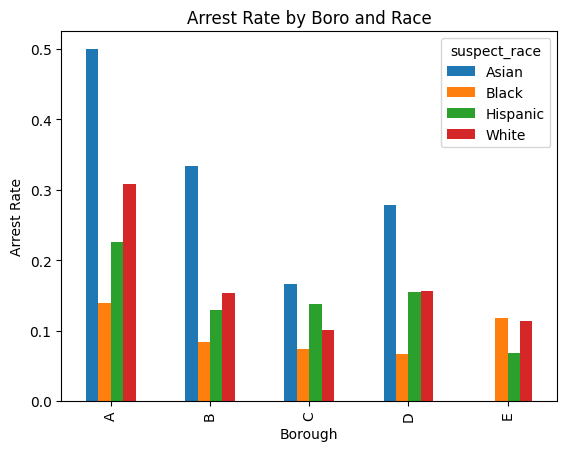

In [25]:
# find arrest rate by boro
boro_race_prior = aggressive_prior[['boro_masked','suspect_race','arrest_flag']].groupby(['boro_masked','suspect_race','arrest_flag']).size().reset_index(name='counts')
boro_race_counts = aggressive_prior.groupby(['boro_masked','suspect_race']).size().reset_index(name='counts')
df_boro_race_prior = pd.DataFrame(boro_race_prior, columns = ["boro_masked",'suspect_race',"arrest_flag","counts"])
df_boro_race_counts = pd.DataFrame(boro_race_counts, columns = ["boro_masked",'suspect_race',"counts"])
df_boro_race_counts = boro_race_counts.rename(columns={"counts":"total"})
df_boro_race_prior.boro_masked = df_boro_race_prior.boro_masked.astype(str)
df_boro_race_counts.boro_masked = df_boro_race_counts.boro_masked.astype(str)
pct_table3 = pd.merge(df_boro_race_prior, df_boro_race_counts, on = ["boro_masked","suspect_race"], how="left")
pct_table3 = pct_table3[(pct_table3['arrest_flag'] != "N")]
pct_table3['percentage'] = pct_table3['counts']/pct_table3['total']
pct_table3 = pct_table3[["boro_masked","suspect_race","percentage"]].set_index(["boro_masked","suspect_race"])["percentage"].unstack()

# graph arrest rate by boro
pct_table3.plot.bar()
plt.ylabel("Arrest Rate")
plt.xlabel("Borough")
plt.title("Arrest Rate by Boro and Race")
plt.show()

# PCA

Now we'll use Principle Component Analysis to hone in on the differences in stop force by race and by boro.

This time we'll pull the 2013 stop data from the NYC.gov website.

In [26]:
# read in sqf-2018 excel sheet
url = "https://www.nyc.gov/assets/nypd/downloads/zip/analysis_and_planning/stop-question-frisk/sqf-2013-csv.zip"
response = requests.get(url, stream=True, verify=False)
with ZipFile(io.BytesIO(response.content)) as myzip:
    with myzip.open(myzip.namelist()[0]) as myfile:
        df = pd.read_csv(myfile)

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/urllib3/connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.nyc.gov'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/tmp/ipykernel_394/1031564497.py:6: DtypeWarning: Columns (10,73,83) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(myfile)


Below we create a list of our police force variables (denoted by `pf_*type-of-force*`), and capture the count and percentage of observations that required such police force.

In [27]:
force_vals = ["pf_hands", "pf_hcuff", "pf_wall", "pf_grnd", "pf_drwep" ,"pf_ptwep" ,"pf_baton", "pf_pepsp", "pf_other"]
force_vals_no_other = ["pf_hands", "pf_grnd" ,"pf_wall", "pf_drwep" ,"pf_ptwep" ,"pf_baton" ,"pf_hcuff" ,"pf_pepsp"]
for ff in force_vals:
    print("Number of %s cases: %d (%.2f%%)" % (ff, len(df[df[ff] == 'Y']), 100*len(df[df[ff] == 'Y'])/len(df)))

Number of pf_hands cases: 25444 (13.26%)
Number of pf_hcuff cases: 9792 (5.10%)
Number of pf_wall cases: 5241 (2.73%)
Number of pf_grnd cases: 895 (0.47%)
Number of pf_drwep cases: 801 (0.42%)
Number of pf_ptwep cases: 658 (0.34%)
Number of pf_baton cases: 18 (0.01%)
Number of pf_pepsp cases: 17 (0.01%)
Number of pf_other cases: 543 (0.28%)


We construct a new column 'force2' to denote if any level of force is ever used in that stop.

In [28]:
# label force as True if any level of force is used
df['force2'] = np.where((df[force_vals]=='Y').any(axis=1), 1, 0)
print("Percent of stops in which force is used: %.2f%%" % (100*len(df[df['force2']==1])/len(df)))

Percent of stops in which force is used: 18.20%


In [29]:
# all precincts
pcts = [  1,   5,   6,   7,   9,  10,  13,  14,  17,  18,  19,  20,  22,
        23,  24,  25,  26,  28,  30,  32,  33,  34,  40,  41,  42,  43,
        44,  45,  46,  47,  48,  49,  50,  52,  60,  61,  62,  63,  66,
        67,  68,  69,  70,  71,  72,  73,  75,  76,  77,  78,  79,  81,
        83,  84,  88,  90,  94, 100, 101, 102, 103, 104, 105, 106, 107,
       108, 109, 110, 111, 112, 113, 114, 115, 120, 121, 122, 123]

We construct a new column 'race2' based on the race information in the original dataset.

In [30]:
# label race
df['asian'] = (df['race'] == 'A')
df['black'] = (df['race'] == 'B') | (df['race'] == 'P')
df['hisp'] = (df['race'] == 'Q')
df['white'] = (df['race'] == 'W')
df['other'] = (df['race'] == 'Z') | (df['race'] == 'I') | (df['race'] == 'U')
df['race2'] = np.where(df['asian'], "asian", "")
df['race2'] = np.where(df['black'], "black", df['race2'])
df['race2'] = np.where(df['hisp'], "hisp", df['race2'])
df['race2'] = np.where(df['white'], "white", df['race2'])
df['race2'] = np.where(df['other'], "other", df['race2'])
df['race2'].value_counts()

race2
black    116720
hisp      42659
white     20820
asian      6845
other      4807
Name: count, dtype: int64

We use 'datetime.strptime()' to convert the date of stop in text to Datetime objects for easier processing of data.

In [31]:
# Clean up date
df['date'] = df['datestop'].apply(lambda d: datetime.strptime(str(d), '%m%d%Y') if len(str(d))==8 \
                                            else datetime.strptime('0'+str(d), '%m%d%Y'))

Next, we transform the use of force data of each race into weekly results and stack the weekly results of the 4 races together.

In [32]:
# weekly force results
def transform_tensor(df):
    dates = [datetime(2013, 1, 1, 0, 0, 0) + timedelta(days=7)*i for i in range(52)]
    forces = [[], [], [], []]
    for i, race in enumerate(['black', 'white', 'hisp', 'asian']):
        for k in pcts:
            v = df[(df['race2']==race) & (df['pct'] == k)]
            force = []
            for day in dates:
                force.append(v[(v['date']>=day) & (v['date'] < day + timedelta(days=7))]['force2'].sum())
            forces[i].append(force)
    return np.array(forces[0]), np.array(forces[1]), np.array(forces[2]), np.array(forces[3])

In [33]:
forces_black, forces_white, forces_hisp, forces_asian = transform_tensor(df)
forces_stacked = np.hstack((forces_black, forces_white, forces_hisp, forces_asian))

Now, we run a PCA analysis. This is done by calling PCA(n_components) first and then .fit_transform(data).


In [34]:
dim = 8
colors = ['#EA212D', '#404DC9', '#FEC832',  '#2DB051']
pca = PCA(n_components=dim)
pca_result = pca.fit_transform(forces_stacked)
assert pca_result.shape == (77, dim)
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.57882685 0.09783131 0.04405505 0.03715437 0.02256483 0.02012554
 0.01949537 0.01569011]


We can see that the first principal component explains 0.5788 of the variation in the data while the second, third and fourth principal component explains 0.0978, 0.0441, 0.0372 of the variance. The other princiapl components explain even smaller proportions of the variance.

Next, we iterate over a bunch of parameters as the number of clusters of KMeans and calculate the silhouette score to see how good is the result.

In [35]:
parameters = [3, 4, 5, 6, 7, 8, 9, 10]
silhouette_scores = []
for num_of_clusters in parameters:
    kmeans = KMeans(n_clusters=num_of_clusters, random_state=0).fit(pca_result)
    ss = silhouette_score(forces_stacked, kmeans.labels_)   # calculate silhouette_score
    silhouette_scores += [ss] # store all the scores
    print('Number of clusters =', num_of_clusters, 'silhouette score', ss)

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Number of clusters = 3 silhouette score 0.29209705441061656
Number of clusters = 4 silhouette score 0.3015368661570199
Number of clusters = 5 silhouette score 0.2703731875549135
Number of clusters = 6 silhouette score 0.26431421323109794
Number of clusters = 7 silhouette score 0.2865229338728553
Number of clusters = 8 silhouette score 0.2894488545032293


/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/cluster/_kmeans.

Number of clusters = 9 silhouette score 0.18201044687178286
Number of clusters = 10 silhouette score 0.1730827101212307


/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


We notice that using 4 clusters gets the highest silhouette score thus we continue with 4 clusters for visualization of the clusters.

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


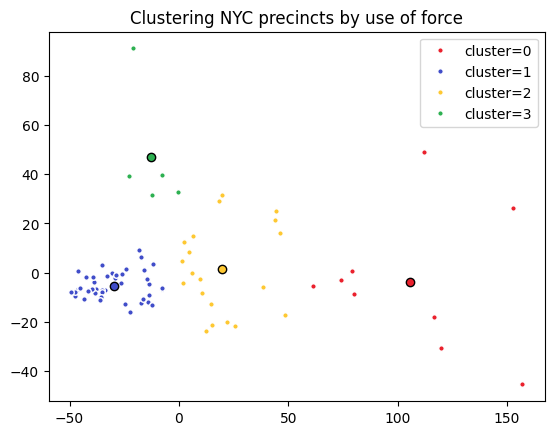

In [36]:
num_of_clusters = 4
kmeans = KMeans(n_clusters=num_of_clusters, random_state=0).fit(pca_result)
k_means_labels = kmeans.labels_
k_means_cluster_centers = kmeans.cluster_centers_

for k, col in zip(range(num_of_clusters), colors):
    my_members = k_means_labels == k
    cluster_center = k_means_cluster_centers[k]
    plt.plot(pca_result[my_members, 0], pca_result[my_members, 1], 'w',
            markerfacecolor=col, marker='.', markersize = 8, label = "cluster=" + str(k))
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
            markeredgecolor='k', markersize=6)
plt.title('Clustering NYC precincts by use of force')
plt.legend()

Based on which cluster each precinct belongs to, we color-code all precincts on the map for a more visual representation.

Text(0.5, 1.0, 'Clustering NYC precincts by use of force')

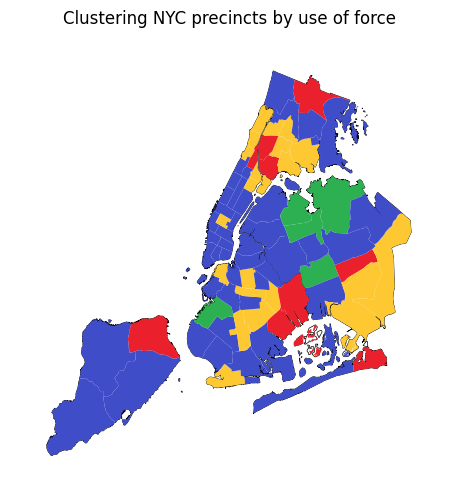

In [37]:
nyc_boroughs = gpd.read_file(gplt.datasets.get_path('nyc_boroughs'))
tickets = gpd.read_file(gplt.datasets.get_path('nyc_parking_tickets'))
tickets['ny'] = k_means_labels

colors = ['#EA212D', '#404DC9', '#FEC832', '#2DB051']
proj = crs.AlbersEqualArea(central_latitude=40.7128, central_longitude=-74.0059)
def plot_state_to_ax(state, ax):
    gplt.choropleth(
        tickets.set_index('id').loc[:, [state, 'geometry']],
        hue=state, cmap = ListedColormap(colors),
        linewidth=0.0, ax=ax
    ) #
    gplt.polyplot(
        nyc_boroughs, edgecolor='black', linewidth=0.5, ax=ax
    )

f, axis = plt.subplots(1, 1, figsize=(6, 6), subplot_kw={'projection': proj})

plot_state_to_ax('ny', axis)
plt.title("Clustering NYC precincts by use of force")

We notice this plot highly coincides with the actual race and ethnicity distribution in real-world as shown below.
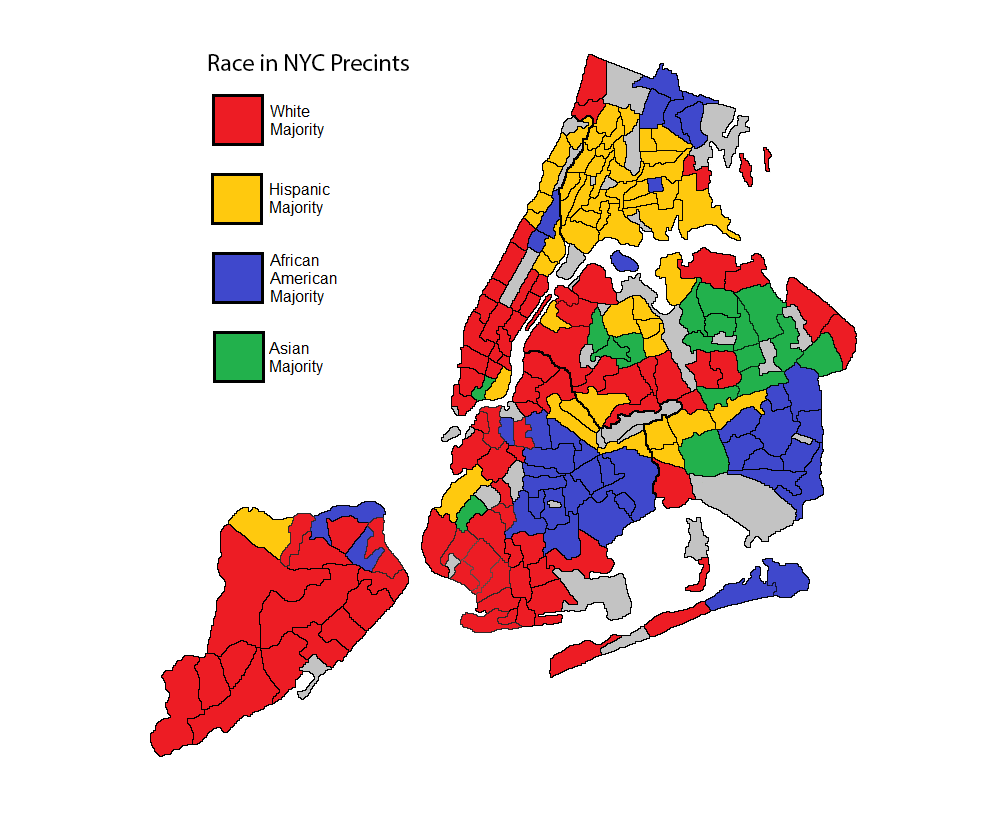